 # Implict Volatility & Social Media Sentiment (StockTwits)

# Intro

- Stocktwits https://stocktwits.com/home

- Midia Social tira insight sentimento de stock traders e investidores, com potencial de um melhor entendimento de stock performance

- Estudo de analises e experimentos usando os dados do Stocktwits

    - Relacionamentos e Metricas que podem agregar valor 
    - Testar API para ver se vale o investimento
    
- StockTwits usa tickers como /$AAPL

- Tweets podem ser categorizados pelos users como BULLISH ou BEARISH 





Produtos Bloomberg e Reuters - Analise Sentimento de Midias Sociais > Twitter & StockTwits

    - Bloomberg Platform 
    
        - Twitter Feeds (TWTR)
        - Monitors unusual bursts of social media chatter
        - Bloomberg Social Velocity (BSV) alert, see social media volume
        - Trending
        - Alerts with SIGNIFICANT positive or negative social sentiment
        - Overall volume of tweets in pos/neg/neutral
   


![title](social-sentiment-592x338.JPG)
   
    - Reuters Eikon Platform 
        
        - Volume of pos/neg tweets
        - 'Advanced technical analysis enables to spor market and company-impacting events as they happen'
        - Identify Key Influencers 
        - Feed
        - Chart of company share price related to average sentiment
        
![title](social-media-monitor-screenshot.PNG)
 
    
![title](cq5dam_thumbnail_470_264.PNG)




    
Pesquisas mais recentes - insights 

1. Nao conseguiram encontrar correlacoes fortes entre Stocktwits/Twitter e precos reais de stocks - > Focar em outras analises
2. Sao informacoes desestruturadas e imprecisas. Se cuidadosamente aplicado, pode ter valor -> Identificar Volatilidade Futura

 
 
 
 
Analises feitas

- Metricas do StockTwits

GERAL

    1. Analise de Trending (mais mencionados)(tickers, setores) [bullish ou bearish]-ok
    2. Correlacoes mencionados juntos-ok
      
    
POR TICKER E/OU SETOR

    3.  Analise de numeros -> Ratios de BULL/BEAR, Ratios de BUY/SELL -ok
    4.  Analise Correlacao e Cointegracao com Volume de Mencoes -ok
    5.  Correlacoes mencionados juntos - ok
    
    
- Analise de Sentimento

    - Categorizar em Pos/Neg/Neutro
        5.  Volume de Indicadores de Sentimento-ok
        6.  Frequencia de Positivo e/ou Negativo baseado em Followers -> Alarme- ok 
        7.  Comparacao com performance
  
    - Usar as categorias bullish/bearish treinar um classificador de sentimento 
        - Comparar sentimento calculado com real sentimento para testar a performance do classificador
       
Futuras Analises 

1. Key Influencers

In [1]:
#Coleta de Dados

import io, json, requests, time, os, os.path, math, urllib
from sys import stdout
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import linear_model
from pandas_datareader.data import get_data_yahoo
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# retorna JSON
def get_response(symbol, older_than, retries=5):
    url = 'https://api.stocktwits.com/api/2/streams/symbol/%s.json?max=%d' % (symbol, older_than-1)
    for _ in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return json.loads(response.content)
        elif response.status_code == 429:
            print(response.content)
            return None
        time.sleep(1.0)
    return None

def get_older_tweets(symbol, num_queries):    
    path = './data/%s.json' % symbol
    if os.path.exists(path):
        # extending an existing json file
        with open(path, 'r') as f:
            data = json.load(f)
            if len(data) > 0:
                older_than = data[-1]['id']
            else:
                older_than = 1000000000000
    else:
        # creating a new json file
        data = []
        older_than = 1000000000000 # any huge number
    
    for i in range(num_queries):
        content = get_response(symbol, older_than)
        if content == None:
            print('Error, an API query timed out')
            break
        data.extend(content['messages'])
        older_than = data[-1]['id']
        stdout.write('\rSuccessfully made query %d' % (i+1))
        stdout.flush()
        time.sleep(0.5)
        
    # escrever dados em um JSON 
    with open(path, 'w') as f:
        json.dump(data, f)
    print('')
    print('Done')
    
# cliente pode fazer apenas 200 requests por hora 
if not os.path.exists('./data'):
    os.mkdir('./data')
    
symbols = symbols = ['AAPL', 'NVDA', 'TSLA', 'AMD', 'JNUG', 'JDST', 'LABU', 'QCOM', 'INTC', 'DGAZ']
tweets_per_symbol = 400 #3000

for symbol in symbols:
    path = './data/%s.json' % symbol
    if os.path.exists(path):
        with open(path, 'r') as f:
            num_tweets = len(json.load(f))
    else:
        num_tweets = 0
    num_queries = int((tweets_per_symbol - num_tweets - 1)/30 + 1)
    if num_queries > 0:
        print('Getting tweets for symbol %s' % symbol)
        get_older_tweets(symbol, num_queries)
        
get_older_tweets('AAPL', 200)

ModuleNotFoundError: No module named 'pandas_datareader'

# Comparing Stock Market Data of AAPL at Yahoo Finance 

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-05-03,145.589996,147.490005,144.270004,147.059998,45404200,147.059998
2017-05-04,146.520004,147.139999,145.809998,146.529999,23309300,146.529999
2017-05-05,146.759995,148.979996,146.759995,148.960007,26787400,148.960007
2017-05-08,149.029999,153.699997,149.029999,153.009995,48427600,153.009995
2017-05-09,153.869995,154.880005,153.449997,153.990005,38058600,153.990005


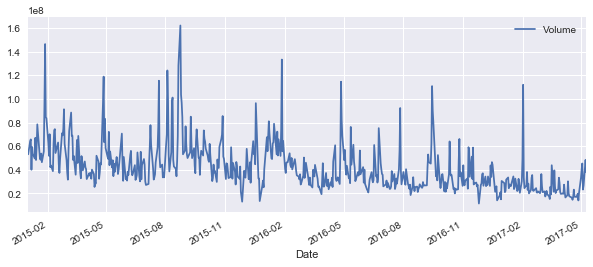

In [2]:
enddate=datetime.now()
startdate=datetime(2015,1,1)
stock_data = get_data_yahoo('AAPL',startdate,enddate)
stock_data['Volume'].plot(legend=True,figsize=(10,4));
stock_data.tail()

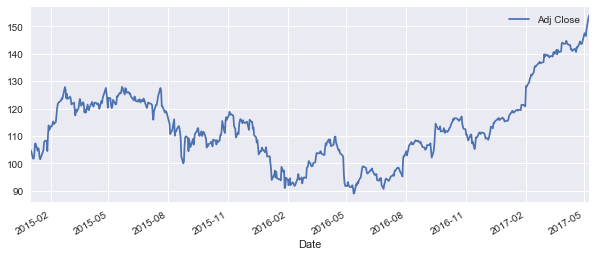

In [3]:
stock_data['Adj Close'].plot(legend=True,figsize=(10,4));

In [38]:
#Transformar em Dataframe

def stocktwits_json_to_df(data, verbose=False):
    columns = ['id','created_at','username','name','user_id','body','basic_sentiment','reshare_count']
    db = pd.DataFrame(index=range(len(data)),columns=columns)
    for i, message in enumerate(data):
        db.loc[i,'id'] = message['id']
        db.loc[i,'created_at'] = message['created_at']
        db.loc[i,'username'] = message['user']['username']
        db.loc[i,'name'] = message['user']['name']
        db.loc[i,'user_id'] = message['user']['id']
        db.loc[i,'body'] = message['body']

#Classificando Bullish e Bearish - +1 BULLISH e -1 BEARISH  
   
        try:
            if (message['entities']['sentiment']['basic'] == 'Bullish'):
                db.loc[i,'basic_sentiment'] = 1
            elif (message['entities']['sentiment']['basic'] == 'Bearish'):
                db.loc[i,'basic_sentiment'] = -1
            else:
                db.loc[i,'basic_sentiment'] = 0
        except:
                db.loc[i,'basic_sentiment'] = 0
                
        db.loc[i,'reshare_count'] = message['reshares']['reshared_count']
        
        for j, symbol in enumerate(message['symbols']):
                db.loc[i,'symbol'+str(j)] = symbol['symbol']
        if verbose:
            #print message
            print(db.loc[i,:])
            
    db['created_at'] = pd.to_datetime(db['created_at'])
    
    return db

filename = 'AAPL.json'
path = 'data/%s' % filename

with open(path, 'r') as f:
    data = json.load(f)
    
db = stocktwits_json_to_df(data)

print('%d exemplos extraidos' % db.shape[0])

enddate = db['created_at'].max()
startdate = db['created_at'].min()
message = db['body']

print(startdate, enddate)

stock_data = get_data_yahoo('AAPL', startdate, enddate)

86305 exemplos extraidos
2016-12-07 16:30:19 2017-05-09 13:33:41


# StockTwits Metrics

# ALL 1.  Trending Analysis (most mentioned) by tickers or sectors

Bullish e Bearish tag


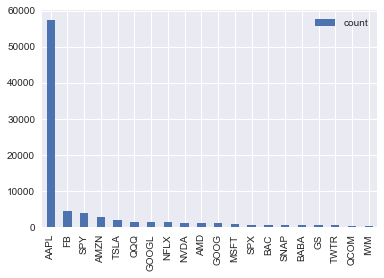

In [3]:
def SO(text):
     userdata = {"text":text}
     resp = requests.post("http://text-processing.com/api/sentiment/", data = userdata)
     return resp.json()
    
stacked = []
unstacked = []

import nltk

for i in data:
  # message = data['symbols']
    try:
        symbols_json = i['symbols']
        symbols =[]
        for symbol_json in symbols_json:
            symbol_real = symbol_json['symbol']
            symbols.append(symbol_real)
        stacked.append(symbols)
     
    except:
         pass
        
unstacked= np.concatenate(stacked)
unique = np.unique(unstacked)

unstacked = np.concatenate(stacked)
unique =np.unique(unstacked)

len(stacked) #total messages with symbols
len(unstacked) #number of total symbols mentioned, with duplicates
len(unique)

stext = nltk.Text(unstacked)
wcount = nltk.FreqDist(stext)
 
v = wcount.values()
b = wcount.keys()

df = pd.DataFrame.from_dict(wcount, orient='index')
df.columns = ['count']
df = df.sort_values('count', ascending = False)
df = df.head(20)
df.plot.bar()
                       

# ALL 2. Correlation - Tickers mentioned together

In [ ]:
import requests 
import json 
import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from collections import Counter
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls


stext = nltk.Text(unstacked)
wcount = nltk.FreqDist(stext)

v = wcount.values()
b = wcount.keys()
df = pd.DataFrame.from_dict(wcount, orient='index')#.reset_index()
    #df = df.head(40)
df.columns = ['count']
df = df.sort_values('count', ascending = False)
    #df = df.head(20)
rowcols  = df.index.values.tolist()
    
def product(a_list):
    prods = []
    for i in range(0,len(a_list)):
        for j in range(0,len(a_list)):
            if i <= j:
                 prods.append(str(a_list[i])+":"+str(a_list[j]))
    return prods

def flip_key(key):
    keys = key.split(":")
    return keys[1]+":"+keys[0]

bins = product(rowcols)
results = pd.DataFrame(np.zeros([1,len(bins)]))
results.columns = bins
    
for stack in stacked :
    combos = product(stack)
    for combo in combos:
        try:
            results[combo] += 1
        except:
            results[flip_key(combo)] += 1
rows =[]
counts = df.transpose()
    
for i in range(0,len(rowcols)):
    cols=[]
    for j in range(0,len(rowcols)):
        key = rowcols[i]+":"+rowcols[j]
        if i<j:
            index = i
        else:
            index = j
        try: 
            cols.append(results[key].values[0]/df.ix[index,0])

        except:
            cols.append(results[flip_key(key)].values[0]/df.ix[index,0])
              
        
    rows.append(cols)
    
corr = pd.DataFrame(rows)
corr.shape
corr.index = rowcols
corr.columns = rowcols
    #corr.to_csv("corr.csv")
    
sns.set(rc={'figure.facecolor':'white'})
ax = sns.heatmap(corr, annot= True, cmap = 'GnBu')
plt.show()

![title](Picture1.PNG)

# BY TICKER 3. Number Analysis: Ratio BULL/BEAR & Ratio BUY/SELL

- Agrupar tweets por dia, para assim tirar ratios

Para cada ticker ou industria/setor

1. Mencoes -> No total de mencoes com ou sem categoria bullish/bearish
2. Categorias -> No total de tweets categorizados em uma data especificada
3. Total -> Soma de Categorias

A. Bull Ratio e Bear Ratio

B. Buy & Sell Ratio

In [40]:
#BULL BEAR RATIO

def tweet_metrics(stock_data, stock_tweets):
    stock_data['mentions'] = np.zeros(stock_data.shape[0])
    stock_data['total_bullish'] = np.zeros(stock_data.shape[0])
    stock_data['total_bearish'] = np.zeros(stock_data.shape[0])
    stock_data['total_predictions'] = np.zeros(stock_data.shape[0])
    stock_data['bull_ratio'] = np.zeros(stock_data.shape[0])
    stock_data['bear_ratio'] = np.zeros(stock_data.shape[0])
    
    for i, d in enumerate(stock_data.index):
        tweets_on_d = stock_tweets[stock_tweets['created_at'].dt.date==d.date()]
        stock_data.loc[d,'mentions'] = tweets_on_d.shape[0]
        stock_data.loc[d,'total_bullish'] = tweets_on_d[tweets_on_d['basic_sentiment']==1].shape[0]
        stock_data.loc[d,'total_bearish'] = tweets_on_d[tweets_on_d['basic_sentiment']==-1].shape[0]
        stock_data.loc[d,'total_predictions'] =  stock_data.loc[d,'total_bearish'] +  stock_data.loc[d,'total_bullish']
        stock_data.loc[d,'bull_ratio'] = stock_data.loc[d,'total_bullish']/float(stock_data.loc[d,'total_predictions'])
        stock_data.loc[d,'bear_ratio'] = stock_data.loc[d,'total_bearish']/float(stock_data.loc[d,'total_predictions'])
    return stock_data


stock_metrics = tweet_metrics(stock_data, db)
print(stock_metrics[['mentions','total_bullish','total_bearish','bull_ratio','bear_ratio']])

            mentions  total_bullish  total_bearish  bull_ratio  bear_ratio
Date                                                                      
2016-12-07     469.0           83.0           22.0    0.790476    0.209524
2016-12-08     682.0          194.0           49.0    0.798354    0.201646
2016-12-09     826.0          252.0           39.0    0.865979    0.134021
2016-12-12     618.0          147.0           75.0    0.662162    0.337838
2016-12-13     893.0          256.0           55.0    0.823151    0.176849
2016-12-14     974.0          260.0          101.0    0.720222    0.279778
2016-12-15     857.0          272.0           79.0    0.774929    0.225071
2016-12-16     616.0          174.0           50.0    0.776786    0.223214
2016-12-19     597.0          137.0           50.0    0.732620    0.267380
2016-12-20     536.0          134.0           64.0    0.676768    0.323232
2016-12-21     718.0          150.0          114.0    0.568182    0.431818
2016-12-22     623.0     

In [ ]:
import urllib.request
import codecs
import json
import datetime

def readfile(input):
    print("\n--------------------------------------------------------------"+input+"---------------------------------------------------")
    
    lineCounter=0
    buyCounter=0
    sellCounter = 0 
    minDate=datetime.datetime.today()+datetime.timedelta(days=1)
    maxDate=datetime.datetime.today()
    
    for i in data:
        
        lineCounter=lineCounter+1
        
        msg = str(i['body'])
        time = str(i['created_at'])
        
        if (datetime.datetime.strptime((time[2:5]+time[8:10]+" "+time[11:19]),'%Y-%m-%d %H:%M:%S')>maxDate):
            maxDate=datetime.datetime.strptime((time[2:5]+time[8:10]+" "+time[11:19]),'%Y-%m-%d %H:%M:%S')
     
        if (datetime.datetime.strptime((time[2:5]+time[8:10]+" "+time[11:19]),'%Y-%m-%d %H:%M:%S')<minDate):
            minDate=datetime.datetime.strptime((time[2:5]+" "+time[8:10]+" "+time[11:19]),'%Y-m-%d %H:%M:%S' )

        if(msg.find("buy")>0 or msg.find("Buy")>0 or msg.find("BUY")>0):
            buyCounter=buyCounter+1
            
        if(msg.find("sell")>0 or msg.find("Sell")>0 or msg.find("SELL")>0):
            sellCounter = sellCounter+1
            
  #      print(str(lineCounter)+" "+time[1:]+" "+"Msg: " + msg[1:])
    print(' ')
    print("Results for "+input+": ")
    print("BUY COUNT: "+str(buyCounter)+" BUY HIT RATIO: "+str(buyCounter/lineCounter)+" DATETIME RANGE FROM "+str(minDate)+" TO "+str(maxDate))
    print("SELL COUNT: "+str(sellCounter)+" SELL HIT RATIO: "+str(sellCounter/lineCounter)+" DATETIME RANGE FROM "+str(minDate)+" TO "+str(maxDate))

readfile('AAPL')
print('')
print('')

![title](Picture2.PNG)

# BY TICKER 4. Correlation & Cointegration between Mentions & Trading Volume

,mentions,Volume
mentions,1.000000,0.684996
Volume,0.684996,1.000000


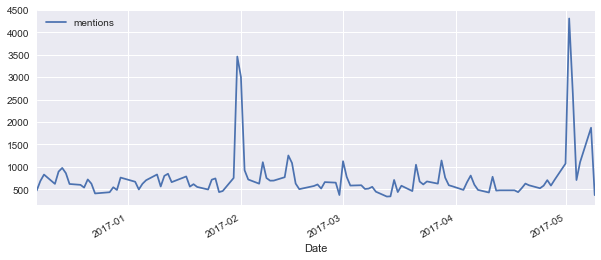

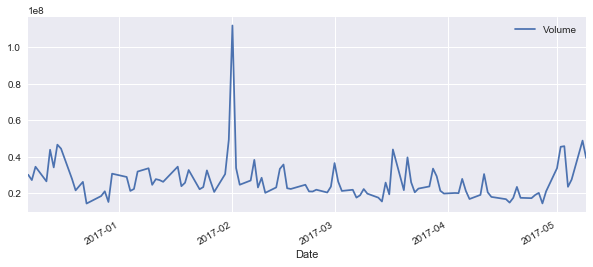

In [41]:
# 1. Comparar numero total de mencoes e Trading Volume

# CORRELACAO
# COITENGRACAO

import statsmodels.formula.api as smf

%matplotlib inline
c = stock_metrics[['mentions']]
d = stock_metrics[['Volume']]
stock_metrics[['mentions']].plot(legend=True,figsize=(10,4))
stock_metrics[['Volume']].plot(legend=True,figsize=(10,4))

combo1 = pd.merge(c,d,left_index=True, right_index=True, how='outer') 

combo1.corr()


In [42]:
model = smf.ols(formula='c~d', data = combo1)
res =model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      c   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     91.05
Date:                Fri, 12 May 2017   Prob (F-statistic):           7.71e-16
Time:                        09:18:16   Log-Likelihood:                -782.51
No. Observations:                 105   AIC:                             1569.
Df Residuals:                     103   BIC:                             1574.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -138.7104    103.330     -1.342      0.182      -343.642    66.221
d           3.367e-05   3.53e-06      9.542      0.000      2.67e-05  4.07e-05
==============================================================================
Omnibus:                      128.949   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3150.097
Skew:                           4.202   Prob(JB):                         0.00
Kurtosis:                      28.483   Cond. No.                     7.36e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ADF Test p-value 0.05 < x < 0.025
1.55885230638e-12
Residuals


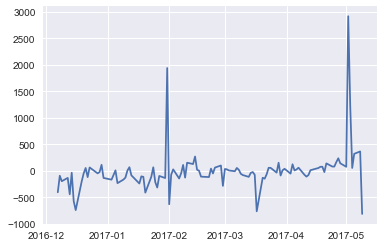

Volume


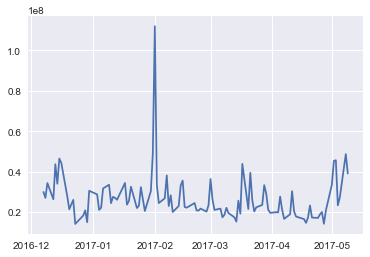

In [43]:
#Residuos Stacionarios ?Se sim, ha cointegracao

import statsmodels.tsa.stattools as sms


adf = sms.adfuller(res.resid)
print('ADF Test p-value 0.05 < x < 0.025')
print(adf[1])

combo1['resid']=res.resid
print('Residuals')
plt.plot(combo1['resid'])
plt.show()
print('Volume') 
plt.plot(combo1[['Volume']])
plt.show()

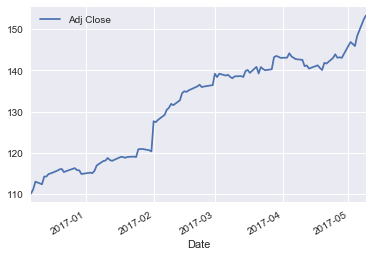

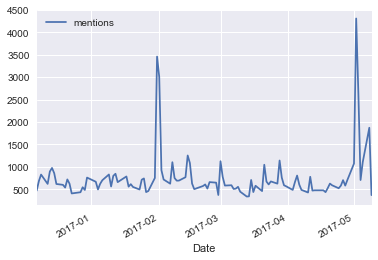

,mentions,Adj Close
mentions,1.000000,0.088976
Adj Close,0.088976,1.000000


In [45]:
# 2. Comparar numero total de mencoes e Adj Close

import pandas as pd
a=pd.DataFrame(stock_metrics[['mentions']])
b=pd.DataFrame(stock_data['Adj Close'])  
#combo = pd.merge(stock_metrics[['mentions']],stock_data['Adj Close'],left_index = True, right_index = True, how ='outer')
combo = pd.merge(a,b,left_index=True, right_index=True, how='outer')
combo = combo.fillna(method='ffill')
combo = combo.dropna()

b.plot()
a.plot()
plt.show()

combo.corr()


,Adj Close,total_bullish
Adj Close,1.000000,0.217356
total_bullish,0.217356,1.000000


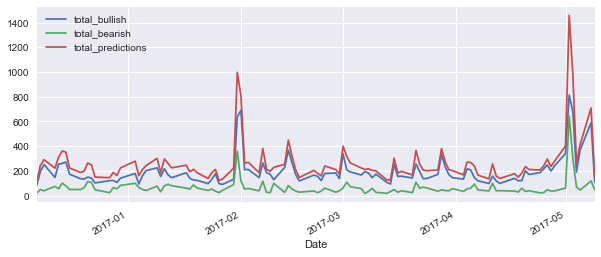

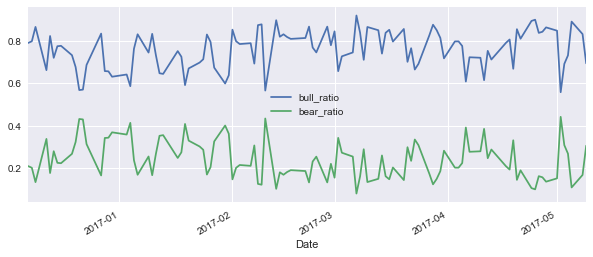

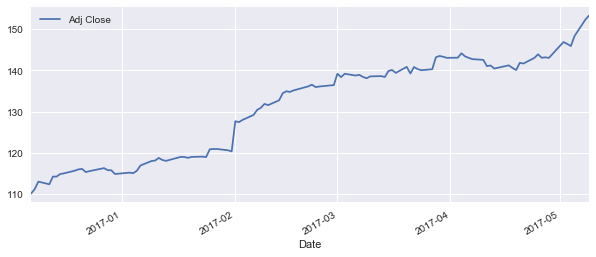

In [46]:
# 2. Comparar closing price com bullish/bearish data do StockTwits 

stock_metrics[['total_bullish','total_bearish','total_predictions']].plot(legend=True,figsize=(10,4));
stock_metrics[['bull_ratio','bear_ratio']].plot(legend=True,figsize=(10,4));
stock_metrics[['Adj Close']].plot(legend=True,figsize=(10,4));

close = pd.DataFrame(stock_metrics['Adj Close'])
sentimentBULL=  pd.DataFrame(stock_metrics['total_bullish'])
sentimentBEAR = pd.DataFrame(stock_metrics['bear_ratio'])
combo = pd.merge(close,sentimentBULL, left_index=True,right_index=True, how='outer')
combo = combo.fillna(method='ffill')
combo = combo.dropna()
combo.corr()

# BY TICKER 5. Connections/Correlations between Tickers & Tweets 
Co-ocorrencia


In [12]:
def countcomentions(df):
    
    def getsymbolset(df):
        symbols = []
        for i, row in df.iterrows():
            for symbol in row:
                if (pd.notnull(symbol)):
                    symbols.append(symbol)
        return set(symbols)
   
    def getallsymbols(df):
        columns = df.columns
        symbolcolumns = []
        for col in columns:
            if col.startswith('symbol'):
                symbolcolumns.append(col)
        return df[symbolcolumns]
        
    def count(df, stock_symbol):
        cnt = Counter()
        for i, row in df.iterrows():
            for sym in row:
                if (sym!=stock_symbol) & pd.notnull(sym):
                    cnt[sym] += 1
        return cnt
    
    df = getallsymbols(df)
    symbolset = getsymbolset(df)
    print(len(symbolset), "total symbols found.")
    co = np.zeros((len(symbolset), len(symbolset)))
    co = pd.DataFrame(co, index=symbolset, columns=symbolset)
    for i, row in df.iterrows():
        for stock_symbol in row:
            for sym in row:
                if (sym!=stock_symbol) & pd.notnull(stock_symbol) & pd.notnull(sym):
                    co.loc[stock_symbol,sym]+=1
    return co
    
co = countcomentions(db)

1888 total symbols found.


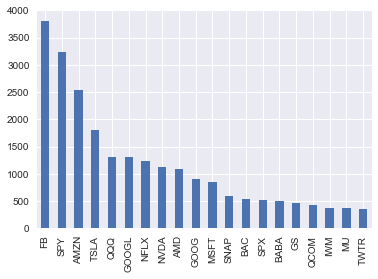

In [13]:
#20 Tickers geralmente correlacionados

corr = co.loc['AAPL',co.loc['AAPL',:]>0].sort_values(ascending=False)[:20]
corr.plot.bar()

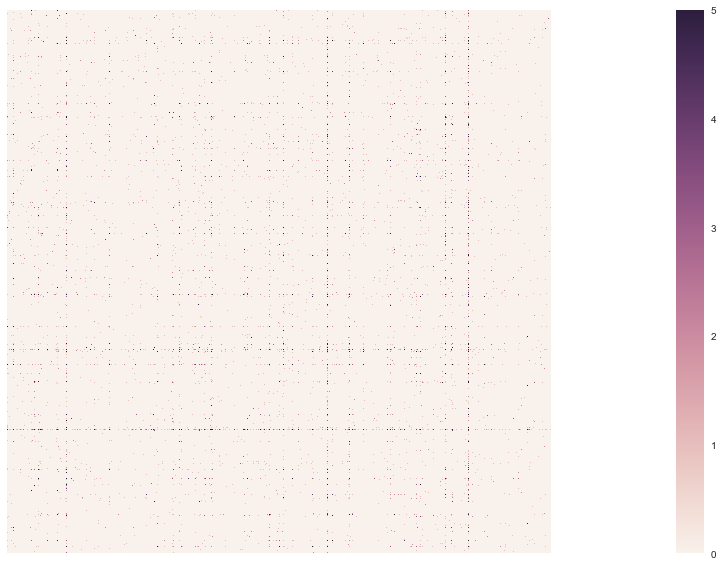

In [14]:
#MST and smaller heatmap (book)
plt.figure(figsize=(45,10))
sns.heatmap(co, xticklabels=False, vmin=0, vmax=5, yticklabels=False, square=True);


# Sentiment Analysis

# POS/NEG/NEUTRAL 1. Sentiment Indicator Volume

In [55]:
def SO(text):
    userdata = {"text":text}
    resp = requests.post("http://text-processing.com/api/sentiment/", data = userdata)
    return resp.json()

stacked = []
for i in datat
    symbols_json = i['messages']
    try:
        symbols =[]
        for symbol_json in symbols_json:
            symbol_real = symbol_json['body']
            try:
                probs = SO(text)["probability"]
                probs["created_at"]= symbols_json['created_at']
                probs["followers"] = i["user"]["followers"]
                probs["created_at"] = i["user"]["created_at"]
                results_list.append(probs)
            except:
                pass

SyntaxError: unexpected EOF while parsing (<ipython-input-55-042d215cc6d9>, line 20)

![title](Picture3.PNG)

# POS/NEG/NEUTRAL 2. Positive Sentiment Frequency by Followers (VWAP)

Possivel Alarme 

In [ ]:
def get_pos_freq():
    time = "2017-04-03T13:53:49Z"
    
    def SO(text, time):
        userdata = {"text":text, "time":time}
        resp = requests.post("http://text-processing.com/api/sentiment/", data = userdata)
        return resp.json()
    
    results_list = []
    for i in data:
        text = i['body']
        time = i["created_at"]
        t = time[:10]
        try:
            #print(text[0:10],t)
            probs = SO(text,time)["probability"]
            probs["followers"] = message["user"]["followers"]
            probs["time"] = message['created_at'][:10]
            probs["created_at"] = message["user"]["created_at"]
            results_list.append(probs)
        except:
            pass
        
    df = pd.DataFrame(results_list) 

    df1 = df.copy()
    df1["wp"] = df1["followers"]*df1["pos"]
    df1["fsum"]= pd.stats.moments.rolling_sum(df1["followers"], window = 30)
    df1["wpsum"] = pd.stats.moments.rolling_sum(df1["wp"], window =30)
    df1["iwap"] = df1["wpsum"]/df1["fsum"]

    r = df1[["iwap"]].plot()
    return r

get_pos_freq()

![title](vwap.PNG)